In [1]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import roc_curve, auc
from keras.utils import to_categorical
from keras.models import load_model
from tensorflow.keras.preprocessing import image


Model = tf.keras.models.Model
VGG19 = tf.keras.applications.VGG19
ResNet50 = tf.keras.applications.ResNet50

GlobalAveragePooling2D = tf.keras.layers.GlobalAveragePooling2D
Dense = tf.keras.layers.Dense
Dropout = tf.keras.layers.Dropout

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from keras.models import Model, load_model
from keras.utils import to_categorical
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import roc_curve, auc, confusion_matrix


class DetectorModelBaseResNet:
    def __init__(self, input_shape=(224, 224, 3)):
        self.input_shape = input_shape
        self._build_model()

    def _build_model(self):
        resnet50_base = tf.keras.applications.ResNet50(weights='imagenet', include_top=False,
                                                       input_shape=self.input_shape)
        x1 = resnet50_base.output
        x1 = tf.keras.layers.GlobalAveragePooling2D()(x1)
        x1 = tf.keras.layers.Dense(1024, activation='relu')(x1)
        x1 = tf.keras.layers.Dropout(0.6)(x1)
        x1 = tf.keras.layers.Dense(512, activation='relu')(x1)
        x1 = tf.keras.layers.Dropout(0.6)(x1)
        predictions = tf.keras.layers.Dense(2, activation='softmax')(x1)

        self.model = Model(inputs=[resnet50_base.input], outputs=[predictions])

        for layer in resnet50_base.layers:
            layer.trainable = False

    def compile(self, optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']):
        self.model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

    def fit(self, train_X, train_Y, batch_size=32, epochs=30, validation_split=0.2, verbose=1):
        train_Y = to_categorical(train_Y, num_classes=2)
        history = self.model.fit(train_X, train_Y, batch_size=batch_size, epochs=epochs, verbose=verbose,
                                 validation_split=validation_split)
        self.history = history
        return history

    def predict(self, X):
        predictions = self.model.predict(X)
        return predictions

    def compute_roc_curve(self, test_X, test_Y):
        y_true = np.argmax(to_categorical(test_Y, num_classes=2), axis=1)
        y_pred = self.predict(test_X)
        y_pred_pos = y_pred[:, 1]

        fpr, tpr, _ = roc_curve(y_true, y_pred_pos)
        roc_auc = auc(fpr, tpr)

        return fpr, tpr, roc_auc

    def plot_roc_curve(self, test_X, test_Y):
        fpr, tpr, roc_auc = self.compute_roc_curve(test_X, test_Y)

        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2,
                 label='ROC curve (area = %0.2f)' % roc_auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    def plot_accuracy(self):
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.plot(self.history.history['accuracy'], label='Training Accuracy')
        plt.plot(self.history.history['val_accuracy'],
                 label='Validation Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(self.history.history['loss'], label='Training Loss')
        plt.plot(self.history.history['val_loss'], label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()

        plt.show()

    def plot_confusion_matrix(self, test_X, test_Y):
        y_pred = self.predict(test_X)
        y_pred = np.argmax(y_pred, axis=1)
        y_true = np.argmax(to_categorical(test_Y), axis=1)
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 10))
        sns.heatmap(cm, annot=True, fmt='d',
                    cmap='coolwarm', cbar=False, linewidth=0.5)
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.show()

    def score(self, test_X, test_Y):
        test_Y = to_categorical(test_Y, num_classes=2)
        score = self.model.evaluate(test_X, test_Y, verbose=0)
        return score

    def save(self, path):
        self.model.save(path)

    def load(self, path):
        self.model = load_model(path)

    def grid_search(self, param_grid, train_X, train_Y, test_X, test_Y, verbose=1):
        best_model = None
        best_score = -np.inf
        best_params = None
        best_history = None

        param_combinations = ParameterGrid(param_grid)

        for params in param_combinations:
            print(f"Training with parameters: {params}")

            self._build_model()
            self.compile(
                optimizer=params['optimizer'], loss=params['loss'], metrics=["accuracy"])
            history = self.fit(
                train_X, train_Y, batch_size=params['batch_size'], epochs=params['epochs'], validation_split=0.2, verbose=verbose)
            score = self.score(test_X, test_Y)

            if score[1] > best_score:
                best_model = self.model
                best_score = score[1]
                best_params = params
                best_history = history

            print(f"Accuracy: {score[1]}")

        self.model = best_model
        self.history = best_history

        print(f"Best parameters: {best_params}")
        print(f"Best accuracy: {best_score}")

        return best_history, best_params


In [3]:
ON_COLAB = True

In [4]:
if ON_COLAB:
    # mound google drive
    from google.colab import drive

    DRIVE_ROOT = "/content/drive"
    DRIVE_DATA_ROOT = os.path.join(DRIVE_ROOT, "My Drive/CP322")
    DRIVE_TRAINING_FOLDER = os.path.join(DRIVE_DATA_ROOT, "Training")
    DRIVE_TESTING_FOLDER = os.path.join(DRIVE_DATA_ROOT, "Testing")

    drive.mount(DRIVE_ROOT)

    MODEL_SAVE_PATH = os.path.join(DRIVE_DATA_ROOT)
    
else:
    DRIVE_ROOT = "../"
    DRIVE_DATA_ROOT = os.path.join(DRIVE_ROOT, "data/raw")
    DRIVE_TRAINING_FOLDER = os.path.join(DRIVE_DATA_ROOT, "Training")
    DRIVE_TESTING_FOLDER = os.path.join(DRIVE_DATA_ROOT, "Testing")
    
    MODEL_SAVE_PATH = os.path.join(DRIVE_ROOT, 'trained-models')

print(DRIVE_ROOT)
print(DRIVE_DATA_ROOT)
print(DRIVE_TRAINING_FOLDER)
print(DRIVE_TESTING_FOLDER)
print(MODEL_SAVE_PATH)

Mounted at /content/drive
/content/drive
/content/drive/My Drive/CP322
/content/drive/My Drive/CP322/Training
/content/drive/My Drive/CP322/Testing
/content/drive/My Drive/CP322


In [5]:
def preprocess_image(img_path, target_size=(224, 224)):
  assert type(target_size) == tuple, "Target size must be of type tuple"
  img = tf.io.read_file(img_path)
  img = tf.image.decode_image(img, channels=3)
  img = tf.image.resize(img, target_size)
  img /= 255.0 # normalize
  return img

def load_data(target="train", limit=200, randomize=True):
  # for now the method only loads all the data as yes or no

  X = []
  Y = []
  # load images that don't have brain tumour
  if target == "train":
    data_dir = DRIVE_TRAINING_FOLDER
  else:
    data_dir = DRIVE_TESTING_FOLDER
  
  no_dir = os.path.join(data_dir, "no")
  files = os.listdir(no_dir)
  if randomize:
    np.random.shuffle(files)
  count = 0
  for img_name in os.listdir(no_dir):
    if count == limit:
      break
    img = preprocess_image(os.path.join(no_dir, img_name))
    X.append(img)
    Y.append(0)
    count += 1
  
  # load images that have brain tumour
  labels = ['pituitary', 'meningioma', 'glioma']
  limit_per_type = [limit // len(labels) if i != len(labels) - 1 else limit // len(labels) + limit % len(labels) for i in range(len(labels))]
  for i in range(len(labels)):
    limit = limit_per_type[i]
    label = labels[i]
    count = 0
    folder = os.path.join(data_dir, label)
    imgs = os.listdir(folder)
    if randomize:
      np.random.shuffle(imgs)
    for img_name in imgs:
      if count == limit:
        break
      img = preprocess_image(os.path.join(folder, img_name))
      X.append(img)
      Y.append(1)
      count += 1
  
  X = np.array(X)
  Y = np.array(Y)

  return X, Y

In [6]:
import tensorflow as tf

if tf.config.list_physical_devices('GPU'):
    print("CUDA is available. GPU:", tf.config.list_physical_devices('GPU')[0])
else:
    print("CUDA is not available.")

CUDA is available. GPU: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [7]:
random_seed = 42
X, Y = load_data(target='train', limit=400)
train_X, test_X, train_Y, test_Y = train_test_split(X, Y, test_size=0.2, random_state=random_seed)
train_X.shape, test_X.shape, train_Y.shape, test_Y.shape

((640, 224, 224, 3), (160, 224, 224, 3), (640,), (160,))

Training with parameters: {'batch_size': 32, 'epochs': 30, 'loss': 'categorical_crossentropy', 'optimizer': 'adam'}
Epoch 1/30
16/16 [==============================] - 7s 246ms/step - loss: 1.1451 - accuracy: 0.5762 - val_loss: 0.7910 - val_accuracy: 0.6562
Epoch 2/30
16/16 [==============================] - 2s 130ms/step - loss: 0.6088 - accuracy: 0.7090 - val_loss: 0.3582 - val_accuracy: 0.8594
Epoch 3/30
16/16 [==============================] - 2s 129ms/step - loss: 0.4432 - accuracy: 0.8047 - val_loss: 0.2992 - val_accuracy: 0.8828
Epoch 4/30
16/16 [==============================] - 2s 145ms/step - loss: 0.3888 - accuracy: 0.8477 - val_loss: 0.2819 - val_accuracy: 0.8906
Epoch 5/30
16/16 [==============================] - 2s 131ms/step - loss: 0.3901 - accuracy: 0.8438 - val_loss: 0.2902 - val_accuracy: 0.8750
Epoch 6/30
16/16 [==============================] - 2s 145ms/step - loss: 0.3555 - accuracy: 0.8555 - val_loss: 0.3679 - val_accuracy: 0.8672
Epoch 7/30
16/16 [==============

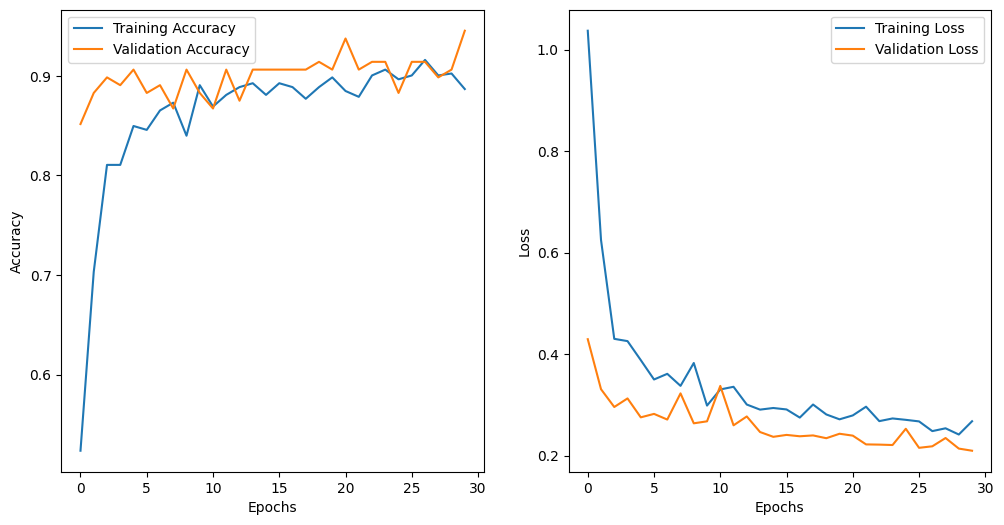

32/32 [==============================] - 4s 97ms/step


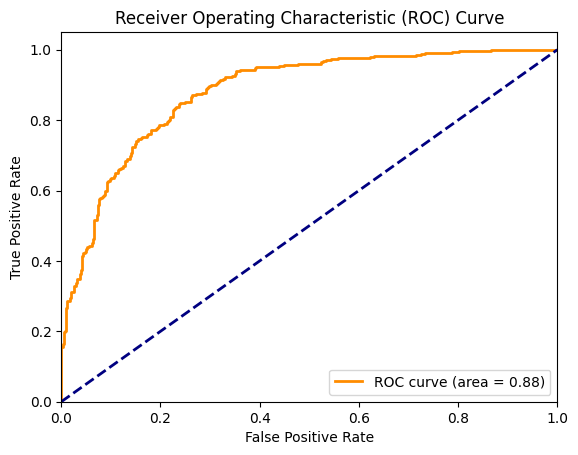

32/32 [==============================] - 3s 97ms/step


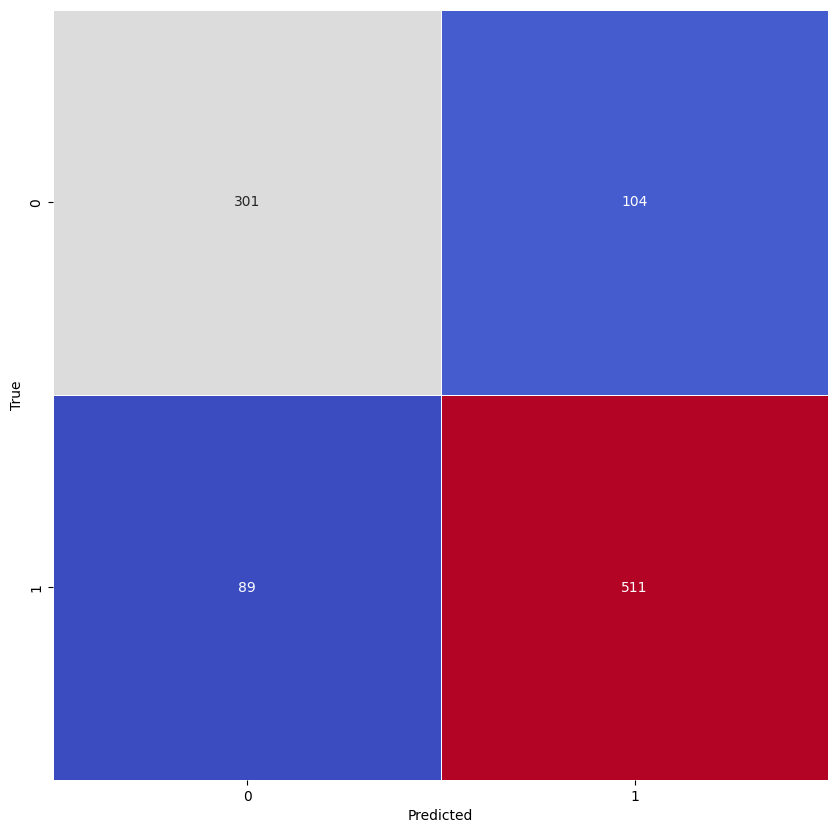

loss: 0.46125540137290955
accuracy: 0.8079602122306824


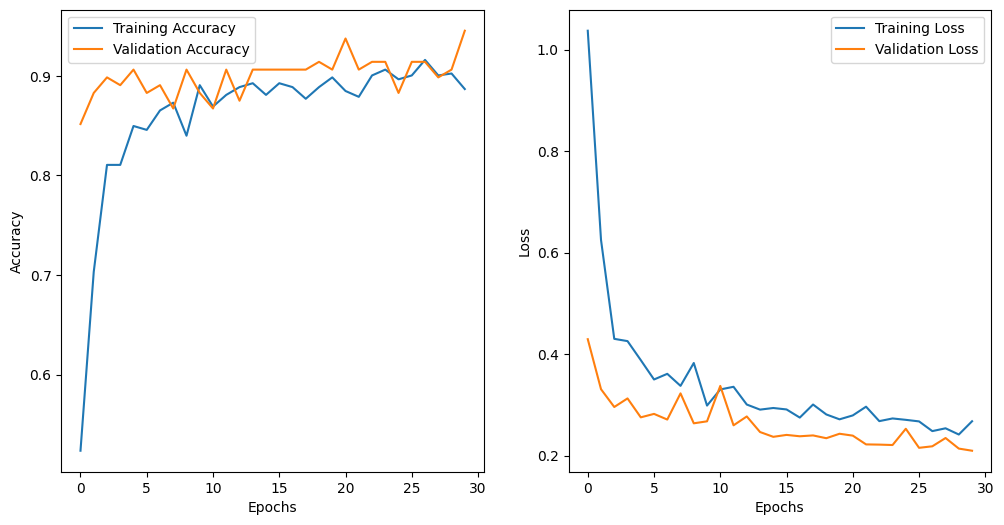

32/32 [==============================] - 3s 96ms/step


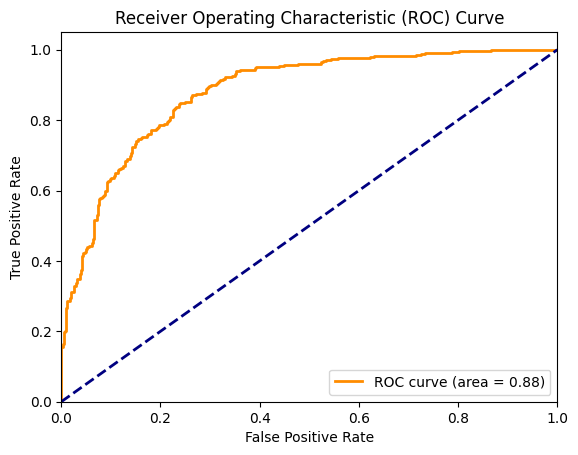

32/32 [==============================] - 3s 99ms/step


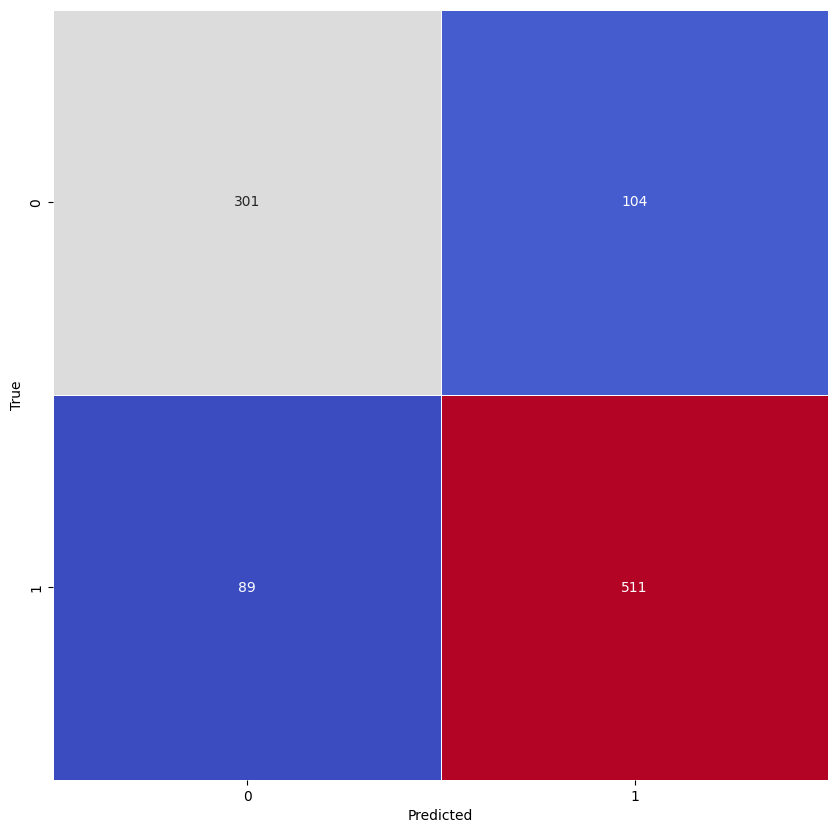

In [14]:
param_grid_resnet = {
    'optimizer': ['adam', 'rmsprop'],
    'loss': ['categorical_crossentropy'],
    'batch_size': [32, 64],
    'epochs': [30],
}

resnet_model = DetectorModelBaseResNet()
resnet_history, resnet_best_params = resnet_model.grid_search(
    param_grid_resnet, train_X, train_Y, test_X, test_Y, verbose=1)

best_resnet_history = resnet_model.fit(train_X, train_Y, batch_size=32, epochs=30, validation_split=0.2)

test_X, test_Y = load_data(target="test", limit=600)

resnet_model = DetectorModelBaseResNet()
resnet_model.compile(
    optimizer=resnet_best_params['optimizer'], loss=resnet_best_params['loss'])

resnet_history = resnet_model.fit(
    train_X, train_Y, batch_size=resnet_best_params['batch_size'], epochs=resnet_best_params['epochs'], validation_split=0.2)

resnet_model.plot_accuracy()
resnet_model.plot_roc_curve(test_X, test_Y)
resnet_model.plot_confusion_matrix(test_X, test_Y)

score = resnet_model.score(test_X, test_Y)


print("loss:", score[0])
print("accuracy:", score[1])

In [15]:
print(resnet_history.history)
resnet_best_params

{'loss': [1.0370430946350098, 0.6247822046279907, 0.4299296438694, 0.4254523515701294, 0.38803139328956604, 0.3498342037200928, 0.36098456382751465, 0.3372821509838104, 0.38233497738838196, 0.2984306812286377, 0.3302091956138611, 0.3354538679122925, 0.3004995286464691, 0.2904609441757202, 0.29367363452911377, 0.29081258177757263, 0.27476322650909424, 0.3005113899707794, 0.28096717596054077, 0.27133989334106445, 0.2790701985359192, 0.29625681042671204, 0.2677936553955078, 0.2730639576911926, 0.27034270763397217, 0.2672499418258667, 0.24813514947891235, 0.25367045402526855, 0.24140046536922455, 0.26756229996681213], 'accuracy': [0.5234375, 0.703125, 0.810546875, 0.810546875, 0.849609375, 0.845703125, 0.865234375, 0.873046875, 0.83984375, 0.890625, 0.869140625, 0.880859375, 0.888671875, 0.892578125, 0.880859375, 0.892578125, 0.888671875, 0.876953125, 0.888671875, 0.8984375, 0.884765625, 0.87890625, 0.900390625, 0.90625, 0.896484375, 0.900390625, 0.916015625, 0.900390625, 0.90234375, 0.886

{'batch_size': 64,
 'epochs': 30,
 'loss': 'categorical_crossentropy',
 'optimizer': 'adam'}

In [16]:
resnet_model.model.save(os.path.join(MODEL_SAVE_PATH, 'resnet.h5'))

In [17]:
model = DetectorModelBaseResNet()
model.load(os.path.join(MODEL_SAVE_PATH, 'resnet.h5'))

32/32 [==============================] - 4s 99ms/step


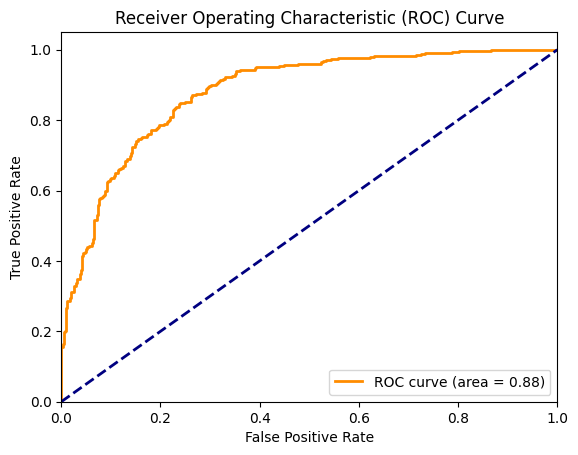

In [18]:
model.plot_roc_curve(test_X, test_Y)

32/32 [==============================] - 3s 100ms/step


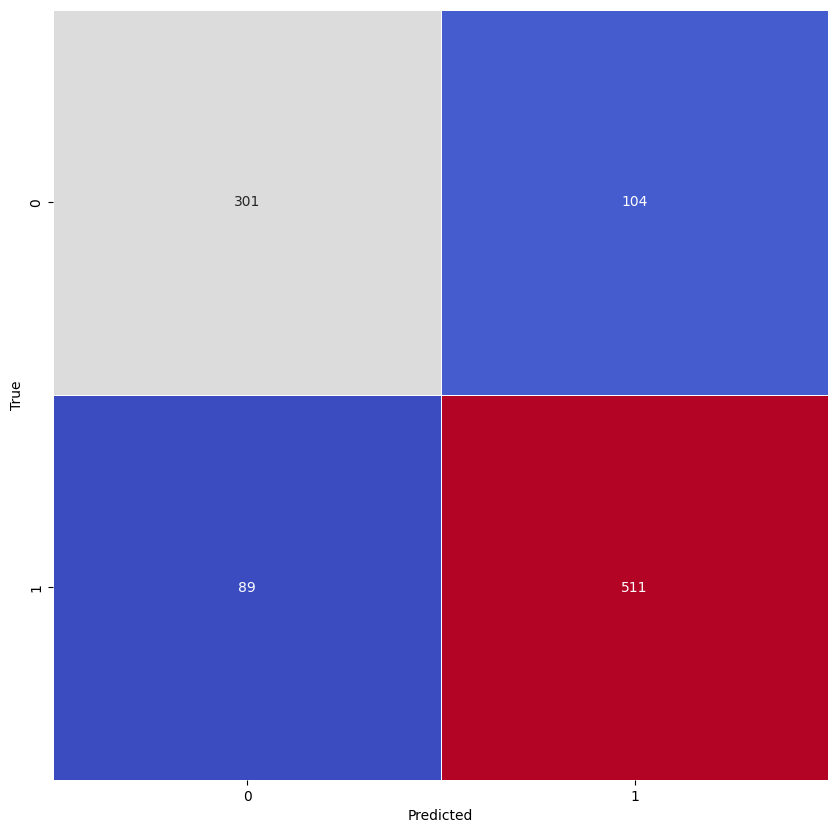

In [19]:
model.plot_confusion_matrix(test_X, test_Y)